In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

#---------------------------------------------------------------------------#
__author__ = 'Song Huang'
__email__ = 'shuang89@ucsc.edu'
__version__ = '170901A'

from __future__ import print_function, \
    division, \
    absolute_import

#---------------------------------------------------------------------------#
import os
import sys
import math
import glob
import copy
import warnings
import subprocess

import sep
import photutils

import numpy as np
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# Numba related
try:
    import numba
    from numba import jit
    use_numba = True
except Exception: 
    use_numba = False
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
# To avoid conflict with isophote.Ellipse
from matplotlib.patches import Ellipse as mpl_ellip
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc('text', usetex=True)

# Astropy related
from astropy import wcs
from astropy.io import fits
from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
from astropy import units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval, \
    PercentileInterval, \
    AsymmetricPercentileInterval

# Scipy related
from scipy.interpolate import LSQUnivariateSpline
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# About the Colormaps
IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = photutils.utils.random_cmap(ncolors=512, background_color=u'white')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')
#---------------------------------------------------------------------------#

In [2]:
#---------------------------------------------------------------------------#
# User imports
from kungpao.isophote.ellipse import Ellipse
from kungpao.isophote.ellipse import Centerer
from kungpao.isophote.ellipse import Geometry
from kungpao.isophote.ellipse.model import build_model

from kungpao.galsbp import galSBP

import hsc_massive
from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    smhm, \
    plotting
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
#envir = s16a_path.set_env(version='astro4')
envir = s16a_path.set_env(version='kungpao')

ORG = plotting.ORG
BLK = plotting.BLK
BLU = plotting.BLU
GRN = plotting.GRN

# For Kungpao
x_images = '/Users/song/iraf/bin.macosx/x_images.e'
x_ttools = '/Users/song/iraf/extern/tables/bin.macosx/x_ttools.e'
x_isophote = '/Users/song/iraf/extern/stsdas/bin.macosx/x_isophote.e'
#---------------------------------------------------------------------------#

In [8]:
from pyraf import iraf

iraf.tables()
iraf.stsdas()
iraf.analysis()
iraf.isophote()

iraf.unlearn('ellipse')
iraf.unlearn('bmodel')



      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |    
      |                  TABLES Version 3.17                       |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |    
      |                   STSDAS Version 3.17                      |
      |                   

# User defined functions

In [3]:
def display_single(img, pixel_scale=0.168,
                   xsize=8, ysize=8, ax=None,
                   stretch='arcsinh', scale='zscale', 
                   contrast=0.25, no_negative=False,
                   lower_percentile=1.0, upper_percentile=99.0,
                   cmap=IMG_CMAP, scale_bar=True,
                   scale_bar_length=20.0, scale_bar_fontsize=20,
                   scale_bar_y_offset=0.5
                   ):
    """
    Display a single image. 
    
    :param img: np 2-D array for image 
    
    :param xsize: int, default = 8
        Width of the image. 
    :param ysize: int, default = 8
        Height of the image. 
    """
    #---------------------------------------------------------------------------#
    if ax is None:
        fig = plt.figure(figsize=(xsize, ysize))
        ax1 = fig.add_subplot(111)
    else: 
        ax1 = ax
    #---------------------------------------------------------------------------#

    #---------------------------------------------------------------------------#
    # Stretch option
    if stretch.strip() is 'arcsinh':
        img_scale = np.arcsinh(img)
    elif stretch.strip() is 'log':
        if no_negative:
            img[img <= 0.0] = 1.0E-10
        img_scale = np.log(img)
    elif stretch.strip() is 'log10':
        if no_negative:
            img[img <= 0.0] = 1.0E-10
        img_scale = np.log10(img)
    elif stretch.strip() is 'linear':
        img_scale = img
    else: 
        raise Exception("# Wrong stretch option.")

    # Scale option
    if scale.strip() is 'zscale':
        zmin, zmax = ZScaleInterval(contrast=contrast).get_limits(img_scale)
    elif scale.strip() is 'percentile':
        zmin, zmax = AsymmetricPercentileInterval(
            lower_percentile=lower_percentile,
            upper_percentile=upper_percentile).get_limits(img_scale)

    ax1.imshow(img_scale, origin='lower', cmap=cmap,
               vmin=zmin, vmax=zmax)
    #---------------------------------------------------------------------------#

    #---------------------------------------------------------------------------#
    # Hide ticks and tick labels
    ax1.tick_params(labelbottom='off', labelleft='off', 
                    axis=u'both', which=u'both', length=0)    
    #---------------------------------------------------------------------------#

    #---------------------------------------------------------------------------#
    # Put scale bar on the image
    (img_size_x, img_size_y) = img.shape
    if scale_bar:
        scale_bar_x_0 = int(img_size_x * 0.95 - 
                            (scale_bar_length / pixel_scale))
        scale_bar_x_1 = int(img_size_x * 0.95)
        scale_bar_y = int(img_size_y * 0.10)
        scale_bar_text_x = (scale_bar_x_0 + scale_bar_x_1) / 2
        scale_bar_text_y = (scale_bar_y * scale_bar_y_offset)
        scale_bar_text = r'$%d^{\prime\prime}$' % int(scale_bar_length)
        scale_bar_text_size = scale_bar_fontsize

        ax1.plot([scale_bar_x_0, scale_bar_x_1], 
                 [scale_bar_y, scale_bar_y], 
                 linewidth=3, c='w', alpha=1.0)
        ax1.text(scale_bar_text_x, scale_bar_text_y, scale_bar_text, 
                 fontsize=scale_bar_text_size,
                 horizontalalignment='center', 
                 color='w')
    #---------------------------------------------------------------------------#
    
    #---------------------------------------------------------------------------#
    if ax is None:
        return fig
    else: 
        return ax1

# Load Data

In [4]:
#---------------------------------------------------------------------------#
# Read the images and get the header (WCS)
gal_img = fits.open('redadd_529_HSC-I_full_img.fits')[0].data
gal_hdr = fits.open('redadd_529_HSC-I_full_img.fits')[0].header
gal_wcs = wcs.WCS(gal_hdr)

gal_bad = fits.open('redadd_529_HSC-I_full_bad.fits')[0].data
gal_sig = fits.open('redadd_529_HSC-I_full_sig.fits')[0].data
gal_psf = fits.open('redadd_529_HSC-I_full_psf.fits')[0].data

gal_img_swap = gal_img.byteswap().newbyteorder()
gal_sig_swap = gal_sig.byteswap().newbyteorder()
gal_bad_swap = gal_bad.byteswap().newbyteorder()
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# Basic information for HSC
hsc_pixel_scale = 0.168 # arcsec/ pixel
hsc_zeropoint = 27.0    # mag

print("# 10 arcsecs == %d pixels" % (10.0 / hsc_pixel_scale))
hsc_pixels_20asec = (20.0 / hsc_pixel_scale)
hsc_pixels_10asec = (10.0 / hsc_pixel_scale)
hsc_pixels_5asec = (5.0 / hsc_pixel_scale)
hsc_pixels_3asec = (3.0 / hsc_pixel_scale)

print("# 0.01/pixel == %6.3f mag/arcsec^2" % (
    -2.5 * np.log10(0.01 / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint)
     )
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# Basic information about the image
(img_size_x, img_size_y) = gal_img.shape
x_cen_pix, y_cen_pix = (img_size_x / 2), (img_size_y / 2)

(psf_size_x, psf_size_y) = gal_psf.shape
x_cen_psf, y_cen_psf = (psf_size_x / 2), (psf_size_y / 2)

ra_cen, dec_cen = gal_wcs.wcs_pix2world(x_cen_pix, y_cen_pix, 1)
ra_cen, dec_cen = float(ra_cen), float(dec_cen)

img_radii_arcsec = (x_cen_pix * hsc_pixel_scale) * math.sqrt(2.0)

print("# Central coordinate: %9.6f, %9.6f" % (ra_cen, dec_cen))
print("# Searching radius for the image: %6.1f arcsec" % img_radii_arcsec)
#---------------------------------------------------------------------------#

# 10 arcsecs == 59 pixels
# 0.01/pixel == 28.127 mag/arcsec^2
# Central coordinate: 140.147266, -0.117204
# Searching radius for the image:  142.7 arcsec


## 1-D profile of the PSF model

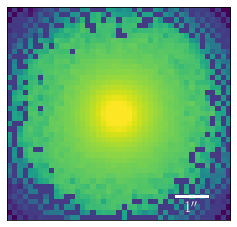

In [5]:
psf_fig = display_single(gal_psf, xsize=4, ysize=4, ax=None,
                         stretch='log', scale='percentile', no_negative=True,
                         lower_percentile=0.5, upper_percentile=99.0,
                         contrast=0.15, scale_bar=True, scale_bar_y_offset=0.20,
                         scale_bar_length=1, scale_bar_fontsize=15.0)

In [16]:
aa, bb = galSBP.galSBP('redadd_529_HSC-I_full_psf.fits', 
                       galX=20.5, galY=21.5, galQ=0.95, galPA=0.0, 
                       maxSma=22, iniSma=4.0, stage=1, intMode='bi-linear',
                       isophote=x_isophote, xttools=x_ttools, ellipStep=0.05,
                       savePng=False)

----------------------------------------------------------------------------------------------------
###      galX, galY :  20.5 21.5
###      galR :  20.0
###      iniSma, maxSma :  10.0 22
###      Stage :  1
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : redadd_529_HSC-I_full_psf.fits
###      Input Image   : temp_WBS71.fits
###      Output Binary : redadd_529_HSC-I_full_psf_ellip_1.bin
----------------------------------------------------------------------------------------------------
----------------

/Users/song/Dropbox/work/project/kungpao/kungpao/galsbp/galSBP.py:1618: RuntimeWarning: invalid value encountered in log10
  expTime))


In [17]:
try: 
    os.remove('redadd_529_HSC-I_full_psf_ellip_1.fits')
except Exception: 
    pass

iraf.bmodel(parent='redadd_529_HSC-I_full_psf.fits', 
            table='redadd_529_HSC-I_full_psf_ellip_1.bin',
            output='redadd_529_HSC-I_full_psf_ellip_1.fits',
            minsma=0.0,
            highar='no')

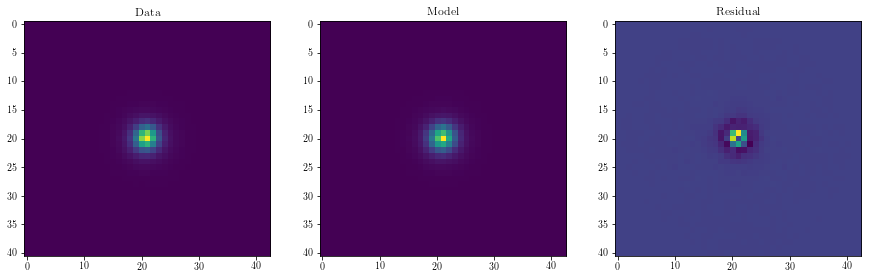

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

ax1.imshow(np.arcsinh(gal_psf))
ax1.set_title(r"$\mathrm{Data}$")

psf_iraf = fits.open('redadd_529_HSC-I_full_psf_ellip_1.fits')[0].data
ax2.imshow(np.arcsinh(psf_iraf))
ax2.set_title(r"$\mathrm{Model}$")

ax3.imshow(np.arcsinh(gal_psf - psf_iraf))
ax3.set_title(r"$\mathrm{Residual}$")

In [17]:
psf_geometry = Geometry(x_cen_psf, y_cen_psf, 
                        3.0, 0.02, (90.0 * np.pi / 180.0))
psf_ellip = Ellipse(gal_psf, geometry=psf_geometry, verbose=False)

psf_isos = psf_ellip.fit_image(sma0=3.0, minsma=0.0, maxsma=(x_cen_psf * 1.01), 
                               step=0.2, sclip=2.0, nclip=1, integrmode='bi-linear', 
                               fixgeom=False, verbose=True)

psf_model = build_model(gal_psf, psf_isos, high_harmonics=False)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
-1
No meaningful fit was possible.


Exception: No Meaningful fit was possible.

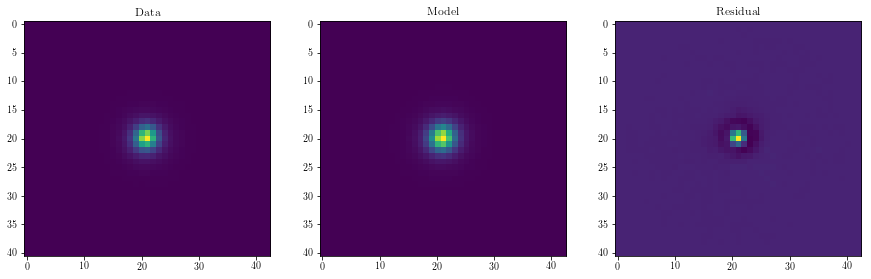

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

ax1.imshow(np.arcsinh(gal_psf))
ax1.set_title(r"$\mathrm{Data}$")

ax2.imshow(np.arcsinh(psf_model))
ax2.set_title(r"$\mathrm{Model}$")

ax3.imshow(np.arcsinh(gal_psf - psf_model))
ax3.set_title(r"$\mathrm{Residual}$")

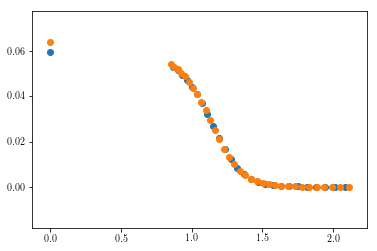

In [10]:
plt.scatter(psf_isos.sma ** 0.25, psf_isos.intens)
plt.scatter(aa['sma'] ** 0.25, aa['intens'])

## Search for stars on the image

In [30]:
#---------------------------------------------------------------------------#
# Search for bright stars in Gaia in time
from astroquery.gaia import Gaia
from astropy.coordinates import ICRS, FK5

img_cen_ra_dec = SkyCoord(ra_cen, dec_cen, unit=('deg', 'deg'), 
                          frame='icrs')

img_search_x = Quantity(hsc_pixel_scale * (gal_img.shape)[0], u.arcsec)
img_search_y = Quantity(hsc_pixel_scale * (gal_img.shape)[1], u.arcsec)

gaia_results = Gaia.query_object_async(coordinate=img_cen_ra_dec, 
                                       width=img_search_x, 
                                       height=img_search_y,
                                       verbose=False)

ra_gaia, dec_gaia = np.asarray(gaia_results['ra']), np.asarray(gaia_results['dec'])
rmask_gaia_arcsec = 694.7 * np.exp(-gaia_results['phot_g_mean_mag'] / 4.04)

x_gaia, y_gaia = gal_wcs.wcs_world2pix(ra_gaia, dec_gaia, 1)

gaia_results.add_column(Column(data=x_gaia, name='x_pix'))
gaia_results.add_column(Column(data=y_gaia, name='y_pix'))
gaia_results.add_column(Column(data=rmask_gaia_arcsec, name='rmask_arcsec'))

# Keep the bright ones
gaia_gmag_limit = 17.5
gaia_bright = gaia_results[gaia_results['phot_g_mean_mag'] <= gaia_gmag_limit]

print("# Gaia finds %d stars and %d with g < %4.2f mag" % (len(gaia_results),
                                                          len(gaia_bright),
                                                          gaia_gmag_limit))
#---------------------------------------------------------------------------#

Launched query: 'SELECT DISTANCE(POINT('ICRS',ra,dec),                 POINT('ICRS',140.147272588,-0.117209164971)) AS dist, *                 FROM gaiadr1.gaia_source WHERE CONTAINS(                POINT('ICRS',ra,dec),                BOX('ICRS',140.147272588,-0.117209164971, 0.0587155555556, 0.0587155555556))=1                 ORDER BY dist ASC'
Retrieving async. results...
Query finished.
# Gaia finds 9 stars and 5 with g < 17.50 mag


# Step by Step test

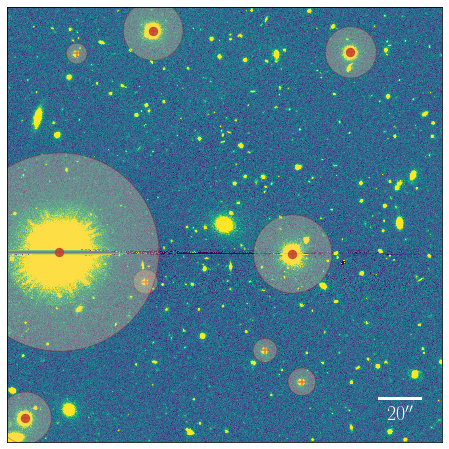

In [34]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

gal_img_zscale = np.arcsinh(gal_img)

zmin, zmax = ZScaleInterval(contrast=0.25).get_limits(gal_img_zscale)

ax1.imshow(gal_img_zscale, origin='lower', cmap=IMG_CMAP,
           vmin=zmin, vmax=zmax)

#---------------------------------------------------------------------------#
# Hide ticks and tick labels
ax1.tick_params(labelbottom='off', labelleft='off', 
                axis=u'both', which=u'both', length=0)    
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# Put scale bar on the image
scale_bar_x_0 = int(img_size_x * 0.95 - hsc_pixels_20asec)
scale_bar_x_1 = int(img_size_x * 0.95)
scale_bar_y = int(img_size_y * 0.10)
scale_bar_text_x = (scale_bar_x_0 + scale_bar_x_1) / 2
scale_bar_text_y = (scale_bar_y * 0.50)
scale_bar_text = r'$20^{\prime\prime}$'
scale_bar_text_size = 20

ax1.plot([scale_bar_x_0, scale_bar_x_1], [scale_bar_y, scale_bar_y], 
         linewidth=3, c='w', alpha=1.0)
ax1.text(scale_bar_text_x, scale_bar_text_y, scale_bar_text, 
         fontsize=scale_bar_text_size,
         horizontalalignment='center', 
         color='w')
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# Show stars
ax1.scatter(gaia_results['x_pix'], 
            gaia_results['y_pix'], c=ORG(0.8), 
            s=70, alpha=0.7, marker='+')

ax1.scatter(gaia_bright['x_pix'] - 1, 
            gaia_bright['y_pix'], c=ORG(0.9), 
            s=70, alpha=0.8)

# Plot an ellipse for each object
for star in gaia_results:
    smask = mpl_ellip(xy=(star['x_pix'], 
                          star['y_pix']),
                      width=(2.0 * star['rmask_arcsec'] / hsc_pixel_scale),
                      height=(2.0 * star['rmask_arcsec'] / hsc_pixel_scale),
                      angle=0.0)
    smask.set_facecolor(ORG(0.3))
    smask.set_edgecolor(ORG(0.9))
    smask.set_alpha(0.3)
    ax1.add_artist(smask)
#---------------------------------------------------------------------------#

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
  50.00        3.13 ( 0.08)  0.000 (0.004)   0.00 ( 0.0)  0.115    85    15    0     4
  55.00        2.36 ( 0.05)  0.000 (0.003)   0.00 ( 0.0)  0.092   103    18    0     4
  60.50        1.77 ( 0.02)  0.000 (0.002)   0.00 ( 0.0)  0.064   106    21    0     4
  66.55        1.30 ( 0.02)  0.000 (0.002)   0.00 ( 0.0)  0.056   111    16    0     4
  73.21        0.95 ( 0.01)  0.000 (0.002)   0.00 ( 0.0)

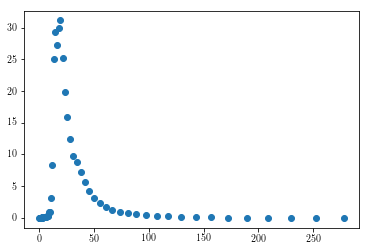

In [28]:
star_use = gaia_bright[0]
star_mod_step = 0.2

star_r_ini, star_e_ini, star_pa_ini = 50.0, 0.00, 0.0
star_r_min, star_r_max = 0.0, (star_use['rmask_arcsec'] / hsc_pixel_scale * 1.1)
star_geom = Geometry(star_use['x_pix'] - 1, 
                     star_use['y_pix'], 
                     star_r_ini, star_e_ini, star_pa_ini)
star_ellip = Ellipse(gal_img, geometry=star_geom, verbose=False)

try:
    star_isos = star_ellip.fit_image(sma0=star_r_ini, 
                                     minsma=star_r_min, 
                                     maxsma=star_r_max, 
                                     step=0.10, linear=False, 
                                     integrmode='median', 
                                     sclip=2.0, nclip=3, 
                                     conver=0.07, maxit=80, fflag=0.8,
                                     fixgeom=False, verbose=True)
except Exception: 
    star_isos = star_ellip.fit_image(sma0=star_r_ini, 
                                     minsma=star_r_min, 
                                     maxsma=star_r_max, 
                                     step=0.10, linear=False, 
                                     integrmode='median', 
                                     sclip=2.0, nclip=2, 
                                     conver=0.07, maxit=80, fflag=0.8,
                                     fixgeom=True, verbose=True)
    
star_mod = build_model(gal_img, star_isos, 
                       high_harmonics=False, 
                       step=star_mod_step, 
                       verbose=True)

plt.scatter(star_isos.sma, star_isos.intens)

In [35]:
star_mod = build_model(gal_img, star_isos, 
                       high_harmonics=False, 
                       step=star_mod_step, 
                       verbose=True)

Interpolating....
Done


/Users/song/Dropbox/work/project/kungpao/kungpao/isophote/ellipse/model.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  phi = max((phi + 0.75 / r), PHI_MIN)


SMA=277.8
Done


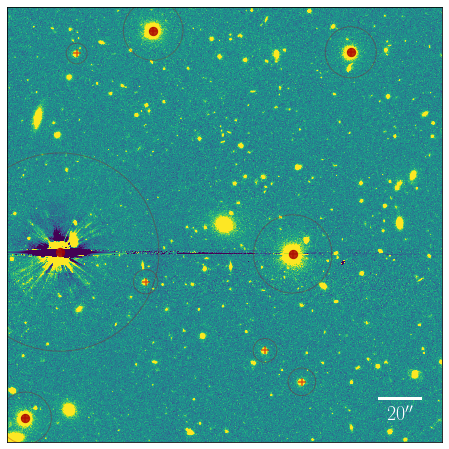

In [36]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

gal_img_zscale = np.arcsinh(gal_img - star_mod)

zmin, zmax = ZScaleInterval(contrast=0.25).get_limits(gal_img_zscale)

ax1.imshow(gal_img_zscale, origin='lower', cmap=IMG_CMAP,
           vmin=zmin, vmax=zmax)

#---------------------------------------------------------------------------#
# Hide ticks and tick labels
ax1.tick_params(labelbottom='off', labelleft='off', 
                axis=u'both', which=u'both', length=0)    
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# Put scale bar on the image
scale_bar_x_0 = int(img_size_x * 0.95 - hsc_pixels_20asec)
scale_bar_x_1 = int(img_size_x * 0.95)
scale_bar_y = int(img_size_y * 0.10)
scale_bar_text_x = (scale_bar_x_0 + scale_bar_x_1) / 2
scale_bar_text_y = (scale_bar_y * 0.50)
scale_bar_text = r'$20^{\prime\prime}$'
scale_bar_text_size = 20

ax1.plot([scale_bar_x_0, scale_bar_x_1], [scale_bar_y, scale_bar_y], 
         linewidth=3, c='w', alpha=1.0)
ax1.text(scale_bar_text_x, scale_bar_text_y, scale_bar_text, 
         fontsize=scale_bar_text_size,
         horizontalalignment='center', 
         color='w')
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# Show stars
ax1.scatter(gaia_results['x_pix'], 
            gaia_results['y_pix'], c=ORG(0.8), 
            s=70, alpha=0.7, marker='+')

ax1.scatter(gaia_bright['x_pix'], 
            gaia_bright['y_pix'], c=ORG(0.9), 
            s=70, alpha=0.8)

# Plot an ellipse for each object
for star in gaia_results:
    smask = mpl_ellip(xy=(star['x_pix'], 
                          star['y_pix']),
                      width=(2.0 * star['rmask_arcsec'] / hsc_pixel_scale),
                      height=(2.0 * star['rmask_arcsec'] / hsc_pixel_scale),
                      angle=0.0)
    smask.set_facecolor('none')
    smask.set_edgecolor(ORG(0.9))
    smask.set_alpha(0.3)
    ax1.add_artist(smask)
#---------------------------------------------------------------------------#

## Try clean the bright stars

## Initial detections

# Detect 478 objects


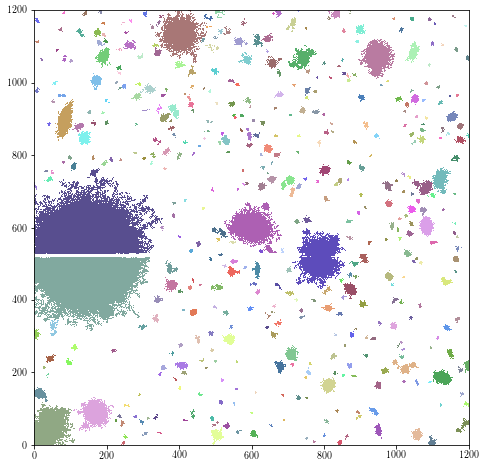

In [24]:
objects, seg = sep.extract(gal_img_swap, 1.5,
                           err=gal_sig_swap, 
                           minarea=20, 
                           deblend_nthresh=24, deblend_cont=0.8,
                           clean=True, clean_param=1.0,
                           segmentation_map=True)

seg_mask = ((seg > 0) | 
            (gal_bad > 0))

print("# Detect %d objects" % len(objects))

plt.figure(figsize=(8, 8))

plt.imshow(seg, origin='lower', cmap=SEG_CMAP, 
           vmin=1, alpha=0.9)

# Mean Sky / RMS Sky =   -0.00213 /    0.05494


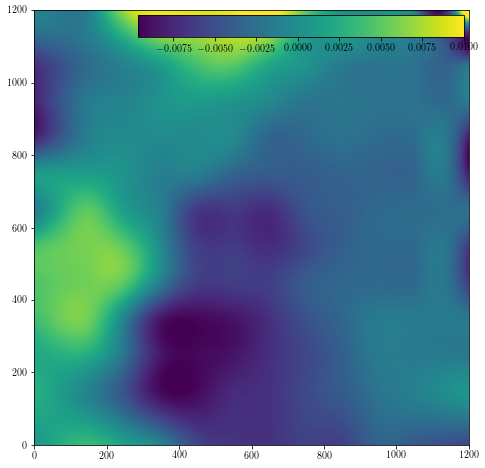

In [25]:
bkg = sep.Background(gal_img_swap, 
                     mask=seg_mask, maskthresh=0,
                     bw=100, bh=100, 
                     fw=5, fh=5)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg.globalback, bkg.globalrms))


fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

sky_zscale = np.arcsinh(bkg.back())

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(sky_zscale)

plt.imshow(sky_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

ax_cbar = inset_axes(ax1, width="75%", height="5%", loc=1) 
plt.colorbar(cax=ax_cbar, orientation='horizontal')

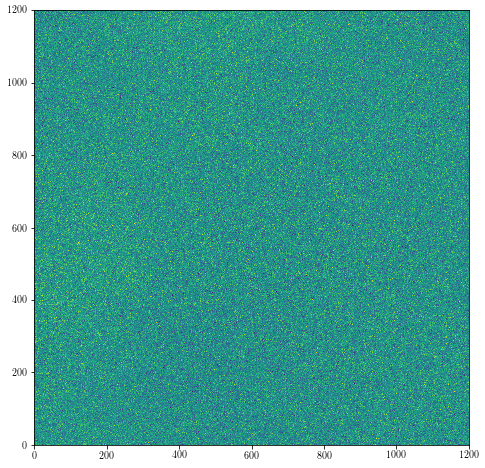

In [306]:
sky_noise_add = np.random.normal(loc=bkg.back(), 
                                 scale=bkg.rms(), 
                                 size=gal_img.shape)

plt.figure(figsize=(8, 8))

sky_noise_zscale = np.arcsinh(sky_noise_add)

zmin, zmax = ZScaleInterval(contrast=0.35).get_limits(sky_noise_zscale)

plt.imshow(sky_noise_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

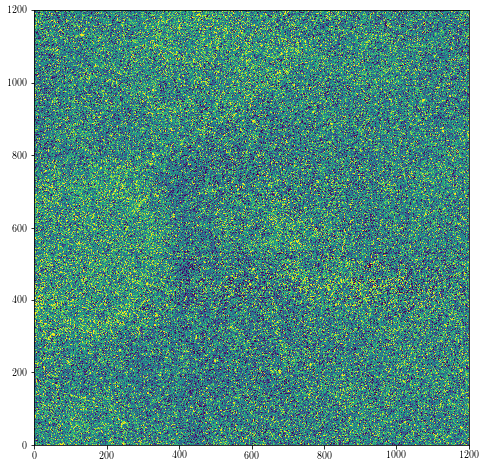

In [307]:
img_noise_replace = copy.deepcopy(gal_img)
img_noise_replace[seg_mask] = sky_noise_add[seg_mask]

plt.figure(figsize=(8, 8))

img_noise_zscale = np.arcsinh(img_noise_replace)

zmin, zmax = ZScaleInterval(contrast=0.8).get_limits(img_noise_zscale)

plt.imshow(img_noise_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

# Mean Sky / RMS Sky =   -0.00152 /    0.05504


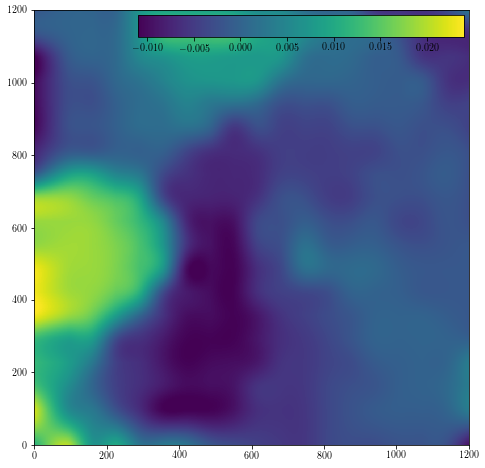

In [308]:
bkg_new = sep.Background(img_noise_replace.byteswap().newbyteorder(), 
                         mask=seg_mask, maskthresh=0,
                         bw=65, bh=65, 
                         fw=4, fh=4)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_new.globalback, bkg_new.globalrms))


fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

sky_new_zscale = np.arcsinh(bkg_new.back())

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(sky_new_zscale)

plt.imshow(sky_new_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

ax_cbar = inset_axes(ax1, width="75%", height="5%", loc=1) 
plt.colorbar(cax=ax_cbar, orientation='horizontal')

# Detect 637 objects on the noise-replaced image


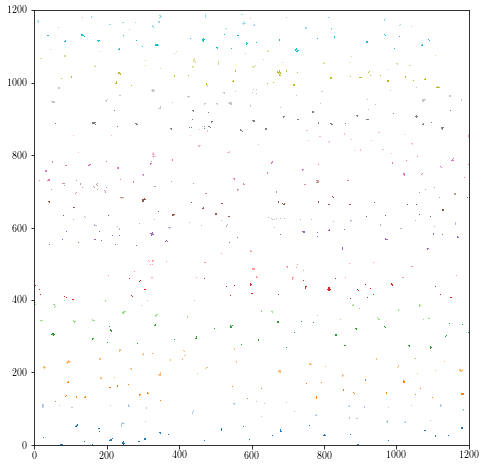

In [309]:
objects_hot, seg_hot = sep.extract(img_noise_replace.byteswap().newbyteorder(), 2.5,
                                   err=gal_sig_swap,
                                   minarea=5, 
                                   deblend_nthresh=24, deblend_cont=0.003,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

seg_mask_hot = seg_hot > 0

print("# Detect %d objects on the noise-replaced image" % len(objects_hot))

plt.figure(figsize=(8, 8))

plt.imshow(seg_hot, origin='lower', cmap=SEG_CMAP, 
           vmin=1)

In [310]:
def seg_remove_cen_obj(seg):
    """
    Remove the central object from the segmentation.
    """
    seg_copy = copy.deepcopy(seg)
    seg_copy[seg == seg[int(seg.shape[0] / 2L), int(seg.shape[1] / 2L)]] = 0
    
    return seg_copy

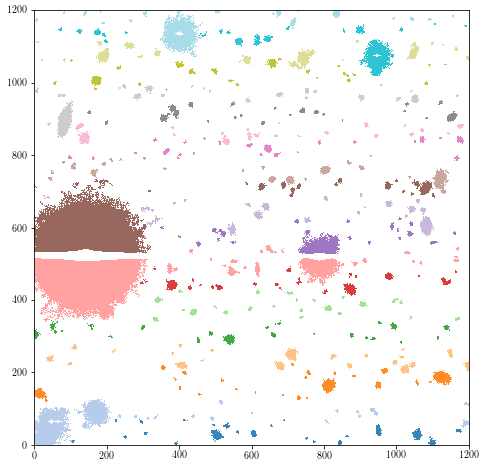

In [311]:
seg_nocen = seg_remove_cen_obj(seg)

plt.figure(figsize=(8, 8))

plt.imshow(seg_nocen, origin='lower', cmap=SEG_CMAP, 
           vmin=1, alpha=0.9)

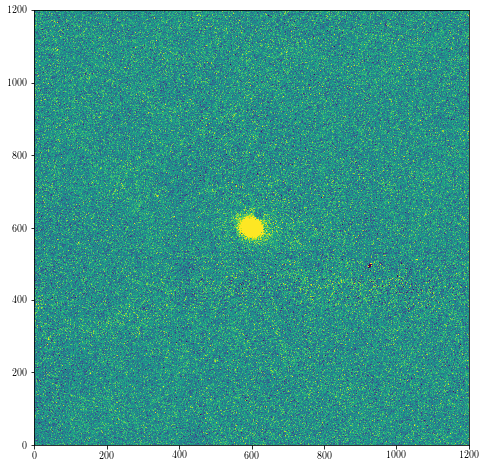

In [312]:
seg_mask_nocen = ((seg_nocen > 0) | 
                  (gal_bad > 0))

img_noise_nocen = copy.deepcopy(gal_img)
img_noise_nocen[seg_mask_nocen] = sky_noise_add[seg_mask_nocen]

img_noise_nocen[seg_mask_hot] = sky_noise_add[seg_mask_hot]

plt.figure(figsize=(8, 8))

img_noise_nocen_zscale = np.arcsinh(img_noise_nocen - bkg_new.back())

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(img_noise_nocen_zscale)

plt.imshow(img_noise_nocen_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

## Check the differences in profile

In [313]:
obj1_geom = Geometry(600.0, 600.0, 4., 0.05, 10./180.*np.pi)

obj1_nomsk_ellip = Ellipse(gal_img, geometry=obj1_geom)

obj1_clean_ellip = Ellipse((img_noise_nocen - bkg_new.back()), geometry=obj1_geom)

gal_img_msk = copy.deepcopy(gal_img - bkg_new.back())
gal_img_msk[seg_mask_nocen] = np.nan

obj1_bgmsk_ellip = Ellipse(gal_img_msk, geometry=obj1_geom)

Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0


In [314]:
obj1_nomsk_iso = obj1_nomsk_ellip.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                            step=0.15, linear=False, integrmode='bi-linear', 
                                            sclip=3., nclip=2, 
                                            conver=0.06, maxit=60, fflag=0.7,
                                            fixgeom=False, verbose=False)

obj1_bgmsk_iso = obj1_bgmsk_ellip.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                            step=0.15, linear=False, integrmode='bi-linear', 
                                            sclip=3., nclip=2, 
                                            conver=0.06, maxit=60, fflag=0.7,
                                            fixgeom=False, verbose=False)

obj1_clean_iso = obj1_clean_ellip.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                            step=0.15, linear=False, integrmode='bi-linear', 
                                            sclip=3., nclip=2, 
                                            conver=0.06, maxit=60, fflag=0.7,
                                            fixgeom=False, verbose=False)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10


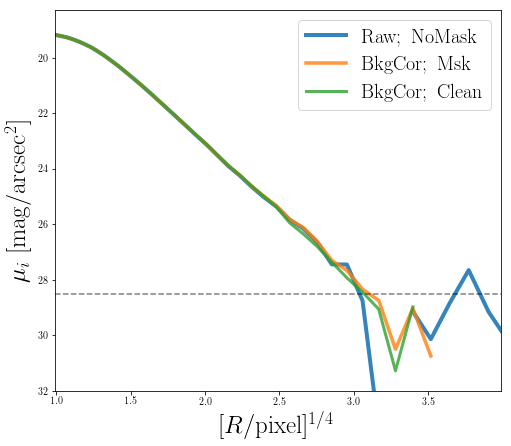

In [315]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         (-2.5 * np.log10(obj1_nomsk_iso.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         (-2.5 * np.log10(obj1_bgmsk_iso.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

#----------------------------------------------------------------------------------------#
rsma = obj1_clean_iso.sma ** 0.25
sbp = (-2.5 * np.log10(obj1_clean_iso.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint)

rsma = rsma[0: np.max(np.argwhere(np.isfinite(sbp)))]
sbp = sbp[0: np.max(np.argwhere(np.isfinite(sbp)))]

flag_use = np.isfinite(sbp)

rsma_use = rsma[np.isfinite(sbp)]
sbp_use = sbp[np.isfinite(sbp)]
nodes = rsma_use[2:-2]

sbp_intrp = LSQUnivariateSpline(rsma_use, sbp_use, nodes)(rsma)
sbp[~flag_use] = sbp_intrp[~flag_use]
#----------------------------------------------------------------------------------------#

ax1.plot(rsma, sbp,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(28.5, linestyle='--', c='k', alpha=0.5)

ax1.set_ylim(31.99, 18.29)
ax1.set_xlim(0.99, 3.99)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mu_{i}\ [\mathrm{mag}/\mathrm{arcsec}^2]$', fontsize=25)

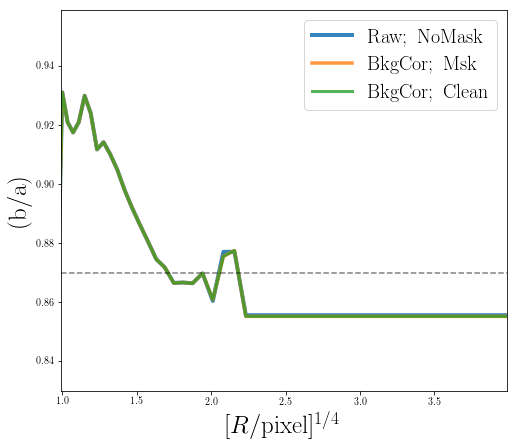

In [316]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         1.0 - obj1_nomsk_iso.eps,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         1.0 - obj1_bgmsk_iso.eps,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         1.0 - obj1_clean_iso.eps,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(0.87, linestyle='--', c='k', alpha=0.5)

ax1.set_ylim(0.83, 0.959)
ax1.set_xlim(0.99, 3.99)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$(\mathrm{b}/\mathrm{a})$', fontsize=25)

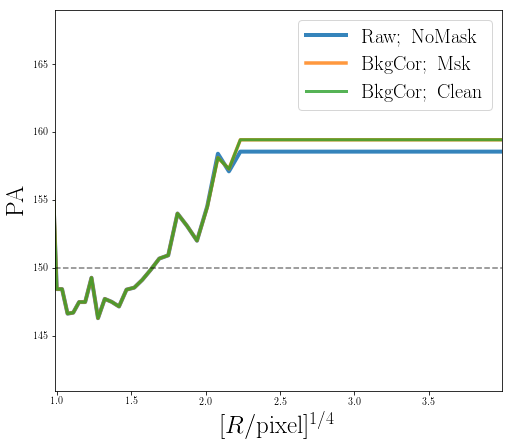

In [317]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         obj1_nomsk_iso.pa * 180.0 / np.pi,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         obj1_bgmsk_iso.pa * 180.0 / np.pi,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         obj1_clean_iso.pa * 180.0 / np.pi,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(150, linestyle='--', c='k', alpha=0.5)

ax1.set_xlim(0.99, 3.99)
ax1.set_ylim(141, 169)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mathrm{PA}$', fontsize=25)

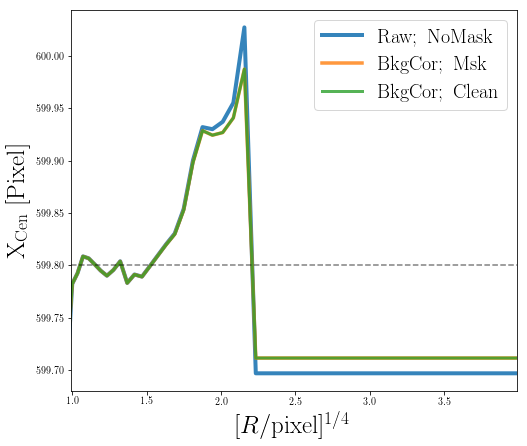

In [318]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         obj1_nomsk_iso.x0,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         obj1_bgmsk_iso.x0,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         obj1_clean_iso.x0,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(599.80, linestyle='--', c='k', alpha=0.5)

ax1.set_xlim(0.99, 3.99)
#ax1.set_ylim(141, 169)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mathrm{X_{\mathrm{Cen}}}\ [\mathrm{Pixel}]$', fontsize=25)

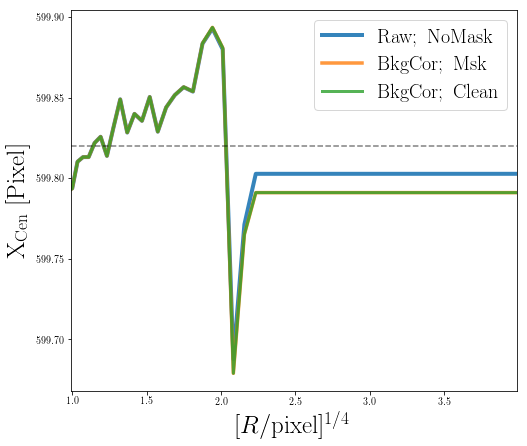

In [319]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         obj1_nomsk_iso.y0,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         obj1_bgmsk_iso.y0,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         obj1_clean_iso.y0,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(599.82, linestyle='--', c='k', alpha=0.5)

ax1.set_xlim(0.99, 3.99)
#ax1.set_ylim(141, 169)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mathrm{X_{\mathrm{Cen}}}\ [\mathrm{Pixel}]$', fontsize=25)

In [320]:
obj1_geom_fix = Geometry(599.80, 599.82, 2., 0.13, (150.0 / 180.0 * np.pi))

obj1_nomsk_ellip_fix = Ellipse(gal_img, geometry=obj1_geom_fix)

obj1_bgmsk_ellip_fix = Ellipse((gal_img_msk - bkg_new.back()), geometry=obj1_geom_fix)

obj1_clean_ellip_fix = Ellipse((img_noise_nocen - bkg_new.back()), geometry=obj1_geom_fix)

Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0


In [321]:
obj1_nomsk_iso_fix = obj1_nomsk_ellip_fix.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                                    step=0.15, linear=False, integrmode='bi-linear', 
                                                    sclip=3., nclip=2, 
                                                    conver=0.06, maxit=60, fflag=0.7,
                                                    fixgeom=True, verbose=False)

obj1_bgmsk_iso_fix = obj1_bgmsk_ellip_fix.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                                    step=0.15, linear=False, integrmode='bi-linear', 
                                                    sclip=3., nclip=2, 
                                                    conver=0.06, maxit=60, fflag=0.7,
                                                    fixgeom=True, verbose=False)

obj1_clean_iso_fix = obj1_clean_ellip_fix.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                                    step=0.15, linear=False, integrmode='bi-linear', 
                                                    sclip=3., nclip=1, 
                                                    conver=0.06, maxit=60, fflag=0.7,
                                                    fixgeom=True, verbose=False)

In [322]:
print(-2.5 * np.log10(np.nanmax(obj1_nomsk_iso_fix.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_bgmsk_iso_fix.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_clean_iso_fix.tflux_e)) + 27.0)

print(-2.5 * np.log10(np.nanmax(obj1_nomsk_iso.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_bgmsk_iso.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_clean_iso.tflux_e)) + 27.0)

16.6342630077 17.9415850542 17.7257416633
16.6524690243 17.9464190843 17.7266099063


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10


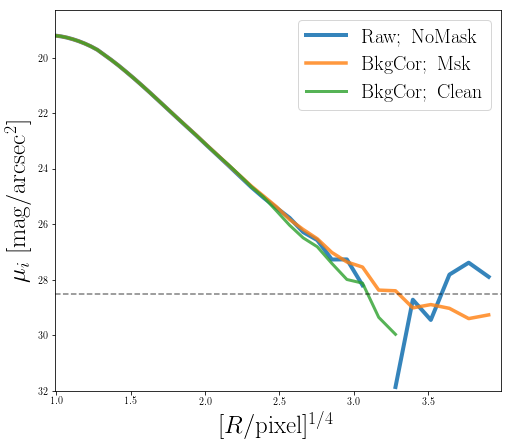

In [323]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso_fix.sma ** 0.25, 
         (-2.5 * np.log10(obj1_nomsk_iso_fix.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso_fix.sma ** 0.25, 
         (-2.5 * np.log10(obj1_bgmsk_iso_fix.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

#----------------------------------------------------------------------------------------#
rsma = obj1_clean_iso_fix.sma ** 0.25
sbp = (-2.5 * np.log10(obj1_clean_iso_fix.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint)

rsma = rsma[0: np.max(np.argwhere(np.isfinite(sbp)))]
sbp = sbp[0: np.max(np.argwhere(np.isfinite(sbp)))]

flag_use = np.isfinite(sbp)

rsma_use = rsma[np.isfinite(sbp)]
sbp_use = sbp[np.isfinite(sbp)]
nodes = rsma_use[2:-2]

sbp_intrp = LSQUnivariateSpline(rsma_use, sbp_use, nodes)(rsma)
sbp[~flag_use] = sbp_intrp[~flag_use]
#----------------------------------------------------------------------------------------#

ax1.plot(rsma, sbp,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(28.5, linestyle='--', c='k', alpha=0.5)

ax1.set_ylim(31.99, 18.29)
ax1.set_xlim(0.99, 3.99)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mu_{i}\ [\mathrm{mag}/\mathrm{arcsec}^2]$', fontsize=25)

# TODO List

    - [ ] Identify central object, do not remove from segmentation image
    - [ ] Identify objects within the inner region, do not remove them from the segmentation image
    - [ ] For brighter objects, grow the footprint a little bit 
    - [ ] 